# Projet 5: notebook d'exploration

Les données textuelles nécessitent un prétraitement important pour pouvoir espérer obtenir des résultats satisfaisants avec des algorithmes de machine learning. Le but de ce notebook est essentiellement d'effectuer ce prétraitement.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from bs4 import BeautifulSoup
import re
import warnings
warnings.filterwarnings('ignore')

# Importation des données

In [2]:
data = pd.read_csv("QueryResults.csv")[["Title", "Body", "Tags"]]

In [3]:
data.head()

,Title,Body,Tags
0,Spring MVC - AngularJS - File Upload - org.apa...,<p>I have a Java Spring MVC Web application as...,<java><spring><angularjs><spring-mvc><file-upl...
1,flutter - how to create forms in popup,<p>I want to create a form inside a pop-up wit...,<flutter><dart><popup><flutter-layout><flutter...
2,Abstraction VS Information Hiding VS Encapsula...,<p>Can you tell me what is the difference betw...,<encapsulation><abstraction><glossary><ooad><i...
3,What Are Some Examples of Design Pattern Imple...,<p>I'm a moderately skilled programmer using J...,<javascript><design-patterns><singleton><strat...
4,What's the best way to get to know linux or BS...,<p>I'd like to gain better knowledge of operat...,<linux><operating-system><kernel><bsd><osdev>


Le but est de prédire les tags à partir des titres ou du corps des questions. On ne sait pas à priori laquelle des deux variables 'Title' ou 'Body' sera la plus utile: peut-être que les titres contiennent trop peu d'informations, mais peut-être que 'Body' engendrera trop de variables.

On va préparer le texte en 3 étapes.

On va commencer par un premier traitement ou on s'intéressera à la casse, la ponctuation, les balises html et quelques exceptions. 

Puis on passera à la tokenisation, avec cette fois-ci des considérations grammaticales.

Enfin, au cours de l'analyse statistique, on supprimera des tokens non pertinents.

# Premier traitement du texte

On utilisera une fonction différente pour chaque variable afin d'optimiser les opérations. En effet, beaucoup d'opérations effectuées pour la variable 'Body' sont inutiles pour la variable 'Tags'.

Une difficulté majeur des données textuelles vient de toutes les exceptions qui peuvent survenir. Dans notre cas les textes vont parler d'informatique or, entre autres choses, certain noms de langage contiennent de la ponctuation. On regroupe quelques exceptions dans le dictionnaire ci-dessous.

In [4]:
dico = {'c#': 'csharp',
        'c++': 'cplusplus',
        '.net': 'dotnet',
        'n-d': 'nd'}

In [5]:
def traitement_tags(text):
    text = text.lower().replace("<", "").replace(">", " ").replace("-", " ")
    # remarquez que la supression des - va scinder des tags en deux 
    for key in dico.keys():
        text = text.replace(key, dico[key])
    return text

def traitement_titres(text, dico):
    text = text.lower()
    for key in dico.keys():
        text = text.replace(key, dico[key])
    text = re.sub(r'[^\w\s]', ' ', text).replace(' js ', ' javascript ')
    return text

def traitement_body(text, dico):
    soup = BeautifulSoup(text, 'html.parser')
    for code in soup.find_all('code'): # on supprime toutes les parties de code 
        code.extract()
    
    soup = soup.get_text().lower()
    soup = re.sub(r'http\S+', '', soup) # on retire les url avant d'enlever la ponctuation
    for key in dico.keys():
        soup = soup.replace(key, dico[key])
    soup = re.sub(r'[^\w\s]', ' ', soup).replace('\n', ' ').replace(' js ', ' javascript ')
    return soup

In [6]:
data["Tags"] = data["Tags"].apply(lambda x: traitement_tags(x))
data["Title"] = data["Title"].apply(lambda x: traitement_titres(x, dico))
data["Body"] = data["Body"].apply(lambda x: traitement_body(x, dico))

In [7]:
data

,Title,Body,Tags
0,spring mvc angularjs file upload org apa...,i have a java spring mvc web application as se...,java spring angularjs spring mvc file upload
1,flutter how to create forms in popup,i want to create a form inside a pop up with f...,flutter dart popup flutter layout flutter form...
2,abstraction vs information hiding vs encapsula...,can you tell me what is the difference between...,encapsulation abstraction glossary ooad inform...
3,what are some examples of design pattern imple...,i m a moderately skilled programmer using java...,javascript design patterns singleton strategy ...
4,what s the best way to get to know linux or bs...,i d like to gain better knowledge of operating...,linux operating system kernel bsd osdev
...,...,...,...
27548,how does keras 1d convolution layer work with ...,i am currently developing a text classificatio...,python tensorflow keras conv neural network wo...
27549,clean architecture design pattern,i have some question about this pattern the...,java rest design patterns microservices clean ...
27550,how to do nd distance and nearest neighbor cal...,this question is intended to be a canonical du...,python arrays numpy scikit learn scipy
27551,android studio emulator is not working on wind...,i have windows 11 on my system the system spe...,android studio android emulator avd hypervisor...


Les variables 'Title' et 'Body' que nous avons actuellement seront utilisées pour le word embedding. Mais pour les approches de type 'bag of words' il va falloir une étape de traitement de texte supplémentaire.

# Tokenisation

L'objectif est de ne garder que certains mots à partir des textes contenus dans 'Title' et 'Body'. On créera de nouvelles variables dans le dataframe data.

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

In [9]:
stop_words = set(stopwords.words('english'))

In [10]:
# Pour convertir les phrases en listes de mots
def tokenisation(text):
    text_token = word_tokenize(text)
    return text_token

# Pour ne garder que les noms
def get_nouns(tokens):
    tag_tokens = nltk.pos_tag(tokens)
    return  [w[0] for w in tag_tokens if w[1] == 'NN']

# Pour supprimer les stop words
def remove_stop_words(tokens, stop_words):
    filtered_tokens = [w for w in tokens if not w in stop_words]
    return filtered_tokens

# Pour la lemmatisation des noms
def lemmatisation(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

# Pour la stemmatisation des noms
def stemmatisation(tokens):
    snowball = SnowballStemmer("english")
    return [snowball.stem(w) for w in tokens]


On veut une version en 'bag of words' lemmatisée des titres et des 'Body' et une version en 'bag of words' stemmatisée des titres et des 'Body'.

In [11]:
data['title_bow_lem'] = data['Title']
data['body_bow_lem'] = data['Body']
data

,Title,Body,Tags,title_bow_lem,body_bow_lem
0,spring mvc angularjs file upload org apa...,i have a java spring mvc web application as se...,java spring angularjs spring mvc file upload,spring mvc angularjs file upload org apa...,i have a java spring mvc web application as se...
1,flutter how to create forms in popup,i want to create a form inside a pop up with f...,flutter dart popup flutter layout flutter form...,flutter how to create forms in popup,i want to create a form inside a pop up with f...
2,abstraction vs information hiding vs encapsula...,can you tell me what is the difference between...,encapsulation abstraction glossary ooad inform...,abstraction vs information hiding vs encapsula...,can you tell me what is the difference between...
3,what are some examples of design pattern imple...,i m a moderately skilled programmer using java...,javascript design patterns singleton strategy ...,what are some examples of design pattern imple...,i m a moderately skilled programmer using java...
4,what s the best way to get to know linux or bs...,i d like to gain better knowledge of operating...,linux operating system kernel bsd osdev,what s the best way to get to know linux or bs...,i d like to gain better knowledge of operating...
...,...,...,...,...,...
27548,how does keras 1d convolution layer work with ...,i am currently developing a text classificatio...,python tensorflow keras conv neural network wo...,how does keras 1d convolution layer work with ...,i am currently developing a text classificatio...
27549,clean architecture design pattern,i have some question about this pattern the...,java rest design patterns microservices clean ...,clean architecture design pattern,i have some question about this pattern the...
27550,how to do nd distance and nearest neighbor cal...,this question is intended to be a canonical du...,python arrays numpy scikit learn scipy,how to do nd distance and nearest neighbor cal...,this question is intended to be a canonical du...
27551,android studio emulator is not working on wind...,i have windows 11 on my system the system spe...,android studio android emulator avd hypervisor...,android studio emulator is not working on wind...,i have windows 11 on my system the system spe...


On commence par la tokenisation et la suppression de mots.

In [12]:
for c in ['title_bow_lem', 'body_bow_lem']:
    data[c] = data[c].apply(lambda x: tokenisation(x))
    data[c] = data[c].apply(lambda x: get_nouns(x))
    data[c] = data[c].apply(lambda x: remove_stop_words(x, stop_words))

On effectue une copie destinée à être stemmatiser.

In [13]:
data['title_bow_stem'] = data['title_bow_lem']
data['body_bow_stem'] = data['body_bow_lem']

On effectue la lemmatisation et la stemmatisation.

In [14]:
data['title_bow_stem'] = data['title_bow_stem'].apply(lambda x: stemmatisation(x))
data['title_bow_lem'] = data['title_bow_lem'].apply(lambda x: lemmatisation(x))
data['body_bow_stem'] = data['body_bow_stem'].apply(lambda x: stemmatisation(x))
data['body_bow_lem'] = data['body_bow_lem'].apply(lambda x: lemmatisation(x))

On converti aussi 'Tags' en liste de mots.

In [15]:
data['Tags'] = data['Tags'].apply(lambda x: tokenisation(x))
data['Tags'] = data['Tags'].apply(lambda x: list(set(x))) # à cause du dédoublement de certains tags précédement

In [16]:
data

,Title,Body,Tags,title_bow_lem,body_bow_lem,title_bow_stem,body_bow_stem
0,spring mvc angularjs file upload org apa...,i have a java spring mvc web application as se...,"[mvc, spring, angularjs, file, upload, java]","[spring, mvc, angularjs, file, org, apache, fi...","[java, spring, mvc, application, server, angul...","[spring, mvc, angularj, file, org, apach, file...","[java, spring, mvc, applic, server, angularj, ..."
1,flutter how to create forms in popup,i want to create a form inside a pop up with f...,"[layout, form, dart, popup, builder, flutter]","[flutter, popup]","[form, pop, flutter, image, flutter]","[flutter, popup]","[form, pop, flutter, imag, flutter]"
2,abstraction vs information hiding vs encapsula...,can you tell me what is the difference between...,"[abstraction, encapsulation, glossary, hiding,...","[abstraction, v, information, v, encapsulation]","[difference, abstraction, information, hiding,...","[abstract, vs, inform, vs, encapsul]","[differ, abstract, inform, hide, softwar, deve..."
3,what are some examples of design pattern imple...,i m a moderately skilled programmer using java...,"[javascript, strategy, factory, method, design...","[design, javascript]","[programmer, javascript, guru, dom, manipulati...","[design, javascript]","[programm, javascript, guru, dom, manipul, des..."
4,what s the best way to get to know linux or bs...,i d like to gain better knowledge of operating...,"[linux, system, bsd, operating, kernel, osdev]","[way, linux, bsd]","[knowledge, operating, system, management, mem...","[way, linux, bsd]","[knowledg, oper, system, manag, memori, manag,..."
...,...,...,...,...,...,...,...
27548,how does keras 1d convolution layer work with ...,i am currently developing a text classificatio...,"[network, keras, neural, tensorflow, word, con...","[convolution, layer, work, word, classificatio...","[text, classification, tool, validation, accur...","[convolut, layer, work, word, classif, problem...","[text, classif, tool, valid, accuraci, head, c..."
27549,clean architecture design pattern,i have some question about this pattern the...,"[microservices, design, patterns, java, clean,...","[architecture, design, pattern]","[question, pattern, database, layer, work, rea...","[architectur, design, pattern]","[question, pattern, databas, layer, work, real..."
27550,how to do nd distance and nearest neighbor cal...,this question is intended to be a canonical du...,"[scikit, learn, arrays, numpy, scipy, python]","[distance, neighbor]","[question, duplicate, target, distance, shape,...","[distanc, neighbor]","[question, duplic, target, distanc, shape, poi..."
27551,android studio emulator is not working on wind...,i have windows 11 on my system the system spe...,"[avd, 11, emulator, hypervisor, android, studi...","[studio, emulator, whpx]","[system, system, specifiction, edition, home, ...","[studio, emul, whpx]","[system, system, specifict, edit, home, langua..."


Pour ce qui est des tags on peut penser que la lemmatisation ou la stemmatisation ne changera pas grand chose, mais on va quand même vérifier cela lors de l'analyse statistique. Donc on ajoute pour l'instant deux autres versions des tags.

In [17]:
data['tags_stem'] = data['Tags'].apply(lambda x: stemmatisation(x))
data['tags_lem'] = data['Tags'].apply(lambda x: lemmatisation(x))

# Analyse statistique

Il n'y a pas énormément de choses à analyser, le but principal est de supprimer des tokens qui n'apportent pas d'informations. Par exemple le mot 'problem' n'apporte rien sur un site ou des gens posent des questions justement parce qu'ils ont un problème!

Mais avant cela regardons brièvement la longueur des questions.

## Longueur des questions

Sur ce point il est inutile de distinguer la lemmatisation de la stemmatisation puisqu'il y a forcément le même nombre de tokens dans les deux cas.

In [18]:
df = data[['title_bow_lem', 'body_bow_lem', 'tags_lem']]

In [19]:
# Pour compter le nombre de tokens
def get_nbr_tokens(data):
    nbr_tokens = pd.DataFrame()
    for c in data.columns:
        nbr_tokens[c] = data[c].apply(lambda x: len(x))
    return nbr_tokens

In [20]:
nbr_tokens = get_nbr_tokens(df)

nbr_tokens.describe()

,title_bow_lem,body_bow_lem,tags_lem
count,27553.000000,27553.000000,27553.000000
mean,3.123616,23.624469,5.926832
std,1.595205,25.830369,1.064494
min,0.000000,0.000000,3.000000
25%,2.000000,10.000000,5.000000
50%,3.000000,17.000000,6.000000
75%,4.000000,29.000000,6.000000
max,16.000000,739.000000,15.000000


On remarque qu'il y a des lignes sans tokens, on les supprime.

In [21]:
for c in ['title_bow_lem', 'body_bow_lem']:
    data[c] = data[c].apply(lambda x: ' '.join([s for s in x]))
    data = data[data[c]!='']
    data[c] = data[c].apply(lambda x: tokenisation(x))

In [24]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
# Un point rouge indiquera la moyenne dans les boxplots

<AxesSubplot:>

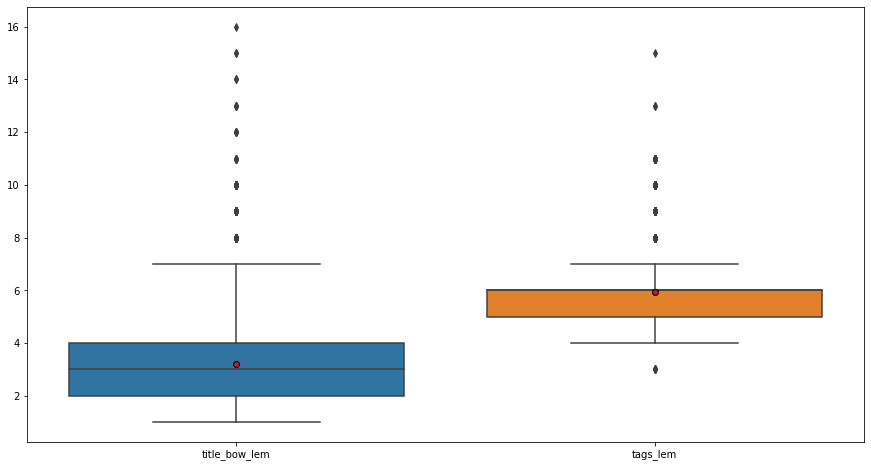

In [25]:
plt.figure(figsize=(15,8))
sns.boxplot(data=nbr_tokens[['title_bow_lem', 'tags_lem']], showmeans=True, meanprops=meanprops)

<AxesSubplot:>

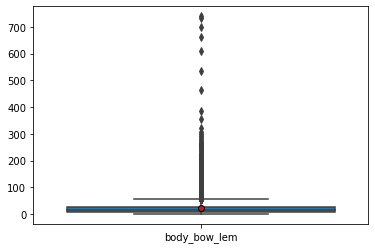

In [26]:
sns.boxplot(data=nbr_tokens[['body_bow_lem']], showmeans=True, meanprops=meanprops)

Les temps de calcul lors des tests sur les versions en bag of words de 'Body' risque d'être significativement plus long que pour les titres.

## Les termes les plus fréquents

Dans un premier temps on va utiliser wordcloud pour afficher des nuages de mots: cela permet de représenter beaucoup d'information sur une petite surface de l'écran. Dans un deuxième temps on tracera des diagrammes en barre pour visualiser, de manière ordonnée, les mots les plus fréquents.

### Avec wordcloud

Ici aussi, il est inutile de distinguer la lemmatisation de la stemmatisation.

In [27]:
from wordcloud import WordCloud

In [28]:
def show_wordcloud_image(data_c):
    l = []
    for i in range(0, data_c.shape[0]):
        l.extend(data_c.iloc[i])
    text = ' '.join(l)
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(14, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

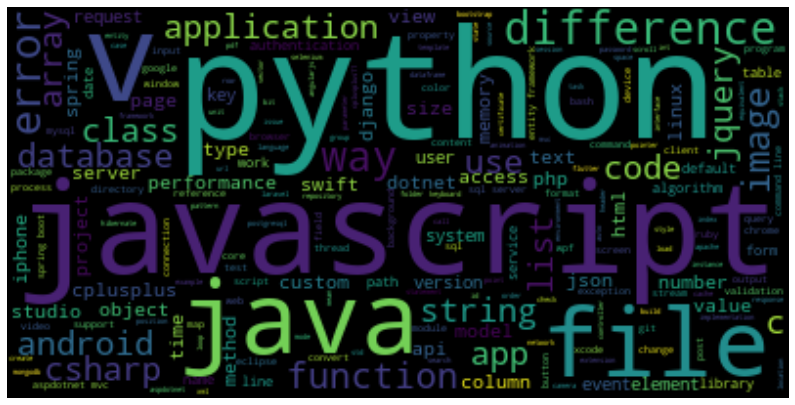

In [29]:
show_wordcloud_image(data['title_bow_lem'])

On voit notamment apparaitre des langages de programation.

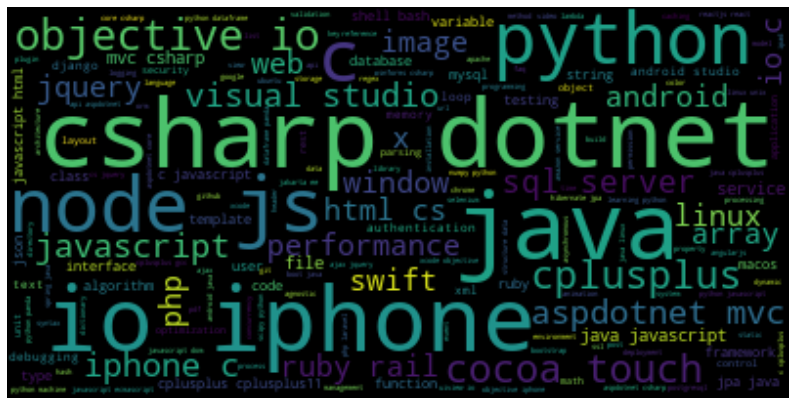

In [30]:
show_wordcloud_image(data['tags_lem'])

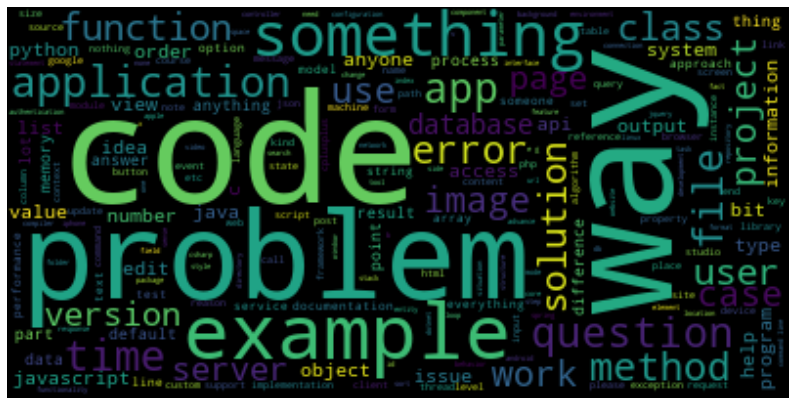

In [31]:
show_wordcloud_image(data['body_bow_lem'])

On voit surtout apparaitre des termes qui ne nous apprennent rien...

### Sans wordcloud

In [32]:
# Pour obtenir le nombre d'occurance des différents tokens
def get_nbr_occurance(data_c):
    l = []
    for i in range(0, data_c.shape[0]):
        l.extend(data_c.iloc[i])
    d = {}
    for word in l:
        if word not in d:
            d[word] = 1
        else:
            d[word] += 1
    df = pd.DataFrame(d, index=['count']).T
    df = df.sort_values(by='count', ascending=False)
    df.reset_index(inplace=True)
    return df

In [33]:
occurance_title_lem = get_nbr_occurance(data['title_bow_lem'])
occurance_body_lem = get_nbr_occurance(data['body_bow_lem'])
occurance_tags_lem = get_nbr_occurance(data['tags_lem'])

In [34]:
occurance_title_stem = get_nbr_occurance(data['title_bow_stem'])
occurance_body_stem = get_nbr_occurance(data['body_bow_stem'])
occurance_tags_stem = get_nbr_occurance(data['tags_stem'])

In [35]:
occurance_tags = get_nbr_occurance(data['Tags'])

In [36]:
# Pour supprimer des tokens inutiles
def removeall(l, a_retirer):
    for o in a_retirer:
        while o in l:
            l.remove(o)
    return l

On se limitera aux 30 tokens les plus fréquents à chaque fois et cette fois il faudra distinguer les versions lemmatiser et stemmatiser pour appliquer la fonction removeall. On commence par les titres.

### Titres

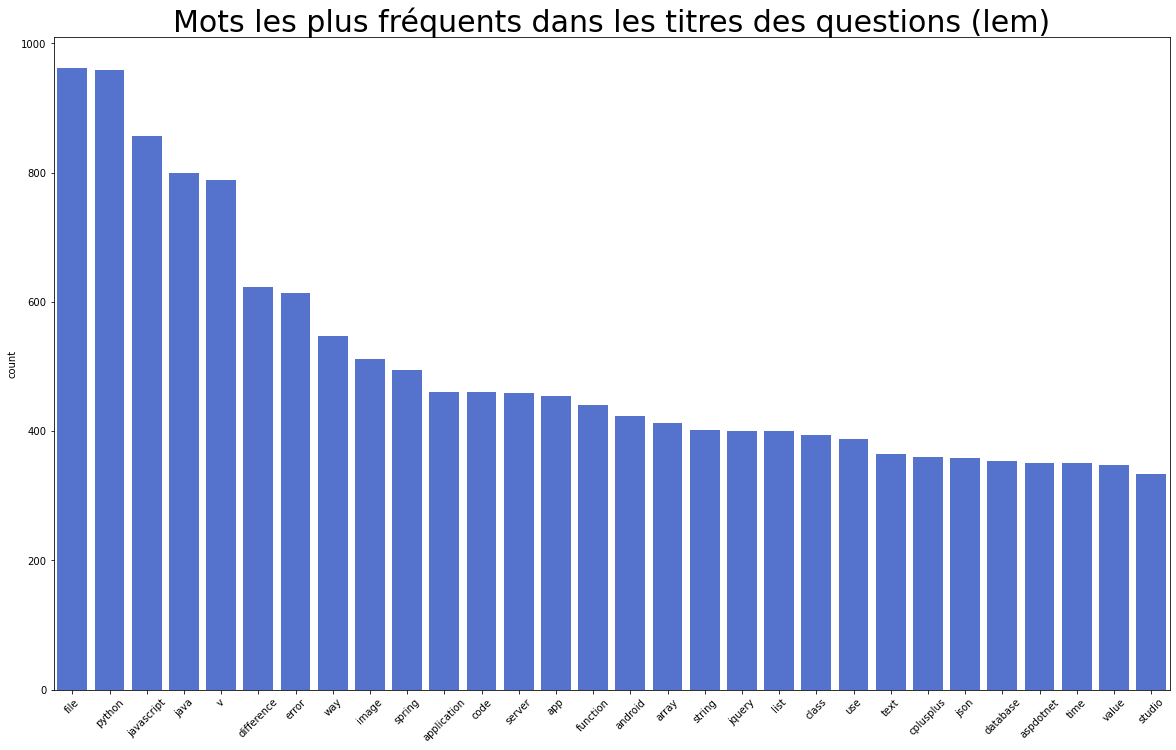

In [37]:
plt.figure(figsize=(20,12))
g = sns.barplot(x=occurance_title_lem.head(30)['index'], y=occurance_title_lem.head(30)['count'], color='royalblue')
g.set_title('Mots les plus fréquents dans les titres des questions (lem)', fontdict = {'fontsize':30})
plt.xticks(rotation=45)
plt.xlabel("")
plt.show()

Il n'y a pas trop de mots parasites, seulement 'error' et 'way' (bien sûre c'est un peu subjectif, mais il faut bien faire des choix).

In [38]:
a_retirer = ['error', 'way']
data['title_bow_lem'] = data['title_bow_lem'].apply(lambda x: removeall(x, a_retirer))

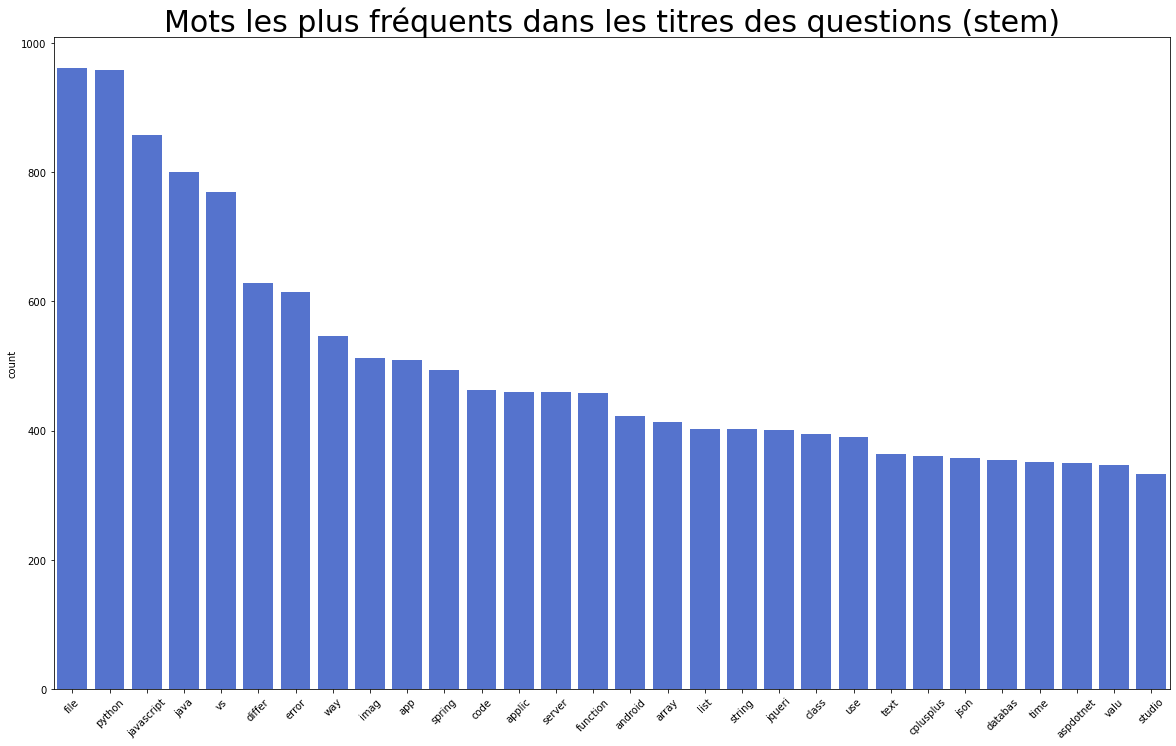

In [39]:
plt.figure(figsize=(20,12))
g = sns.barplot(x=occurance_title_stem.head(30)['index'], y=occurance_title_stem.head(30)['count'], color='royalblue')
g.set_title('Mots les plus fréquents dans les titres des questions (stem)', fontdict = {'fontsize':30})
plt.xticks(rotation=45)
plt.xlabel("")
plt.show()

In [40]:
a_retirer = ['error', 'way']
data['title_bow_stem'] = data['title_bow_stem'].apply(lambda x: removeall(x, a_retirer))

### Body

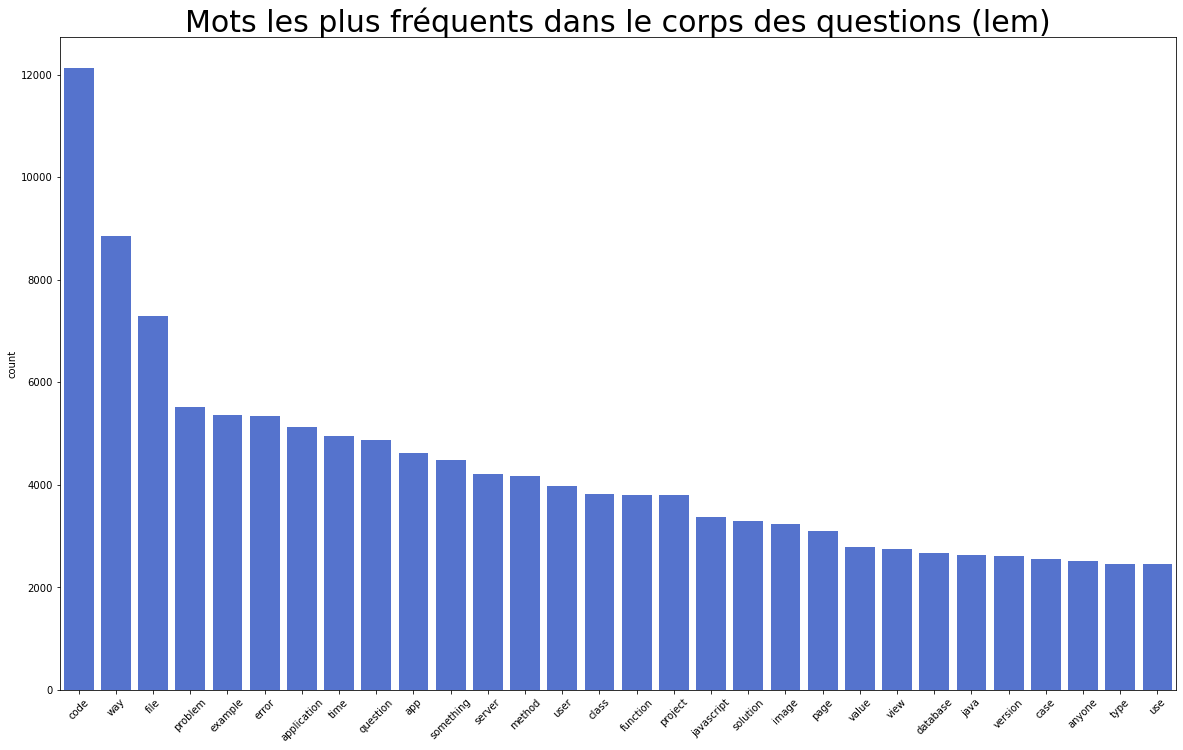

In [41]:
plt.figure(figsize=(20,12))
g = sns.barplot(x=occurance_body_lem.head(30)['index'], y=occurance_body_lem.head(30)['count'], color='royalblue')
g.set_title('Mots les plus fréquents dans le corps des questions (lem)', fontdict = {'fontsize':30})
plt.xticks(rotation=45)
plt.xlabel("")
plt.show()

Comme nous l'avons vu avec wordcloud, il y a beaucoup de mots parasites.

In [42]:
a_retirer = ['code', 'way', 'problem', 'example', 'error', 'question', 'something', 'solution', 'anyone']
data['body_bow_lem'] = data['body_bow_lem'].apply(lambda x: removeall(x, a_retirer))

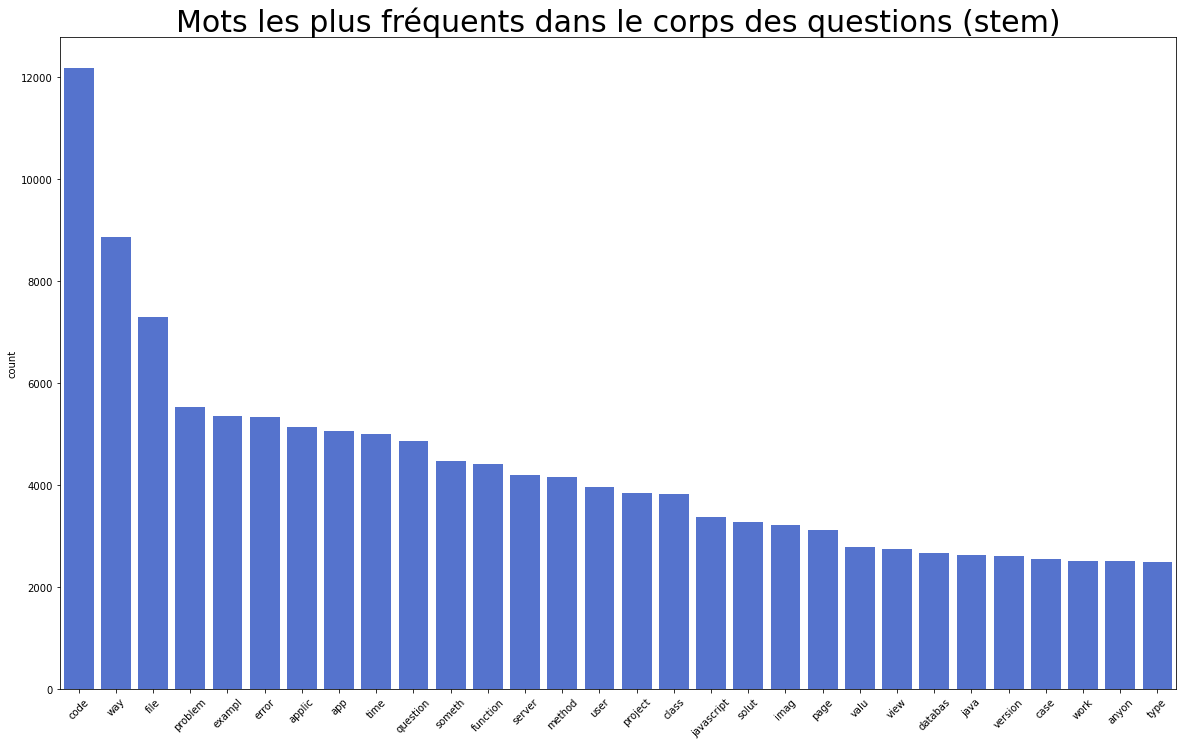

In [43]:
plt.figure(figsize=(20,12))
g = sns.barplot(x=occurance_body_stem.head(30)['index'], y=occurance_body_stem.head(30)['count'], color='royalblue')
g.set_title('Mots les plus fréquents dans le corps des questions (stem)', fontdict = {'fontsize':30})
plt.xticks(rotation=45)
plt.xlabel("")
plt.show()

In [44]:
a_retirer = ['code', 'way', 'problem', 'exampl', 'error', 'question', 'someth', 'solut', 'anyon']
data['body_bow_stem'] = data['body_bow_stem'].apply(lambda x: removeall(x, a_retirer))

Visualisons à nouveau 'data_bow_lem' avec wordcloud.

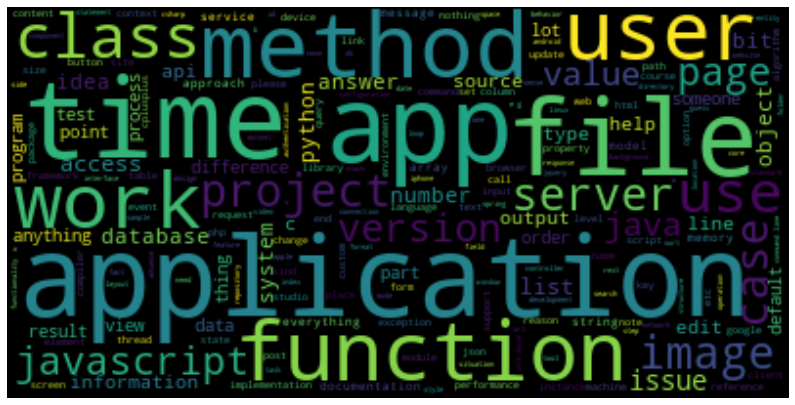

In [45]:
show_wordcloud_image(data['body_bow_lem'])

### Tags

On va voir s'il y a vraiment des différence entre les différentes versions des tags.

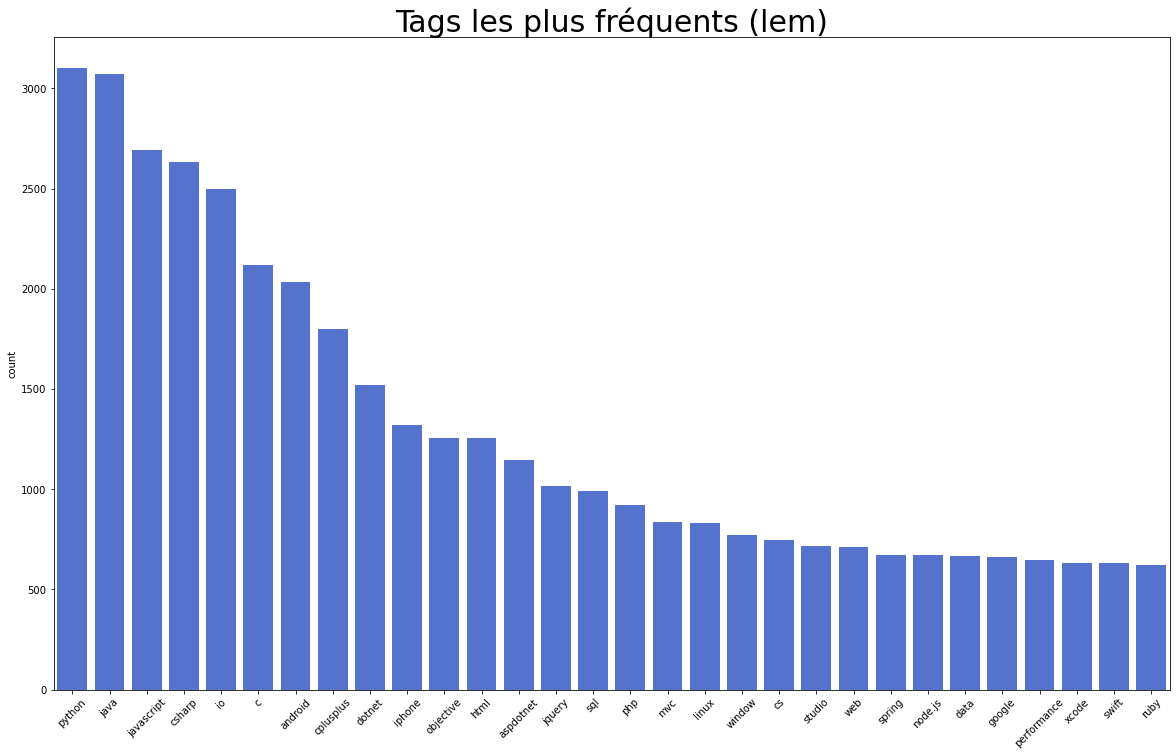

In [46]:
plt.figure(figsize=(20,12))
g = sns.barplot(x=occurance_tags_lem.head(30)['index'], y=occurance_tags_lem.head(30)['count'], color='royalblue')
g.set_title('Tags les plus fréquents (lem)', fontdict = {'fontsize':30})
plt.xticks(rotation=45)
plt.xlabel("")
plt.show()

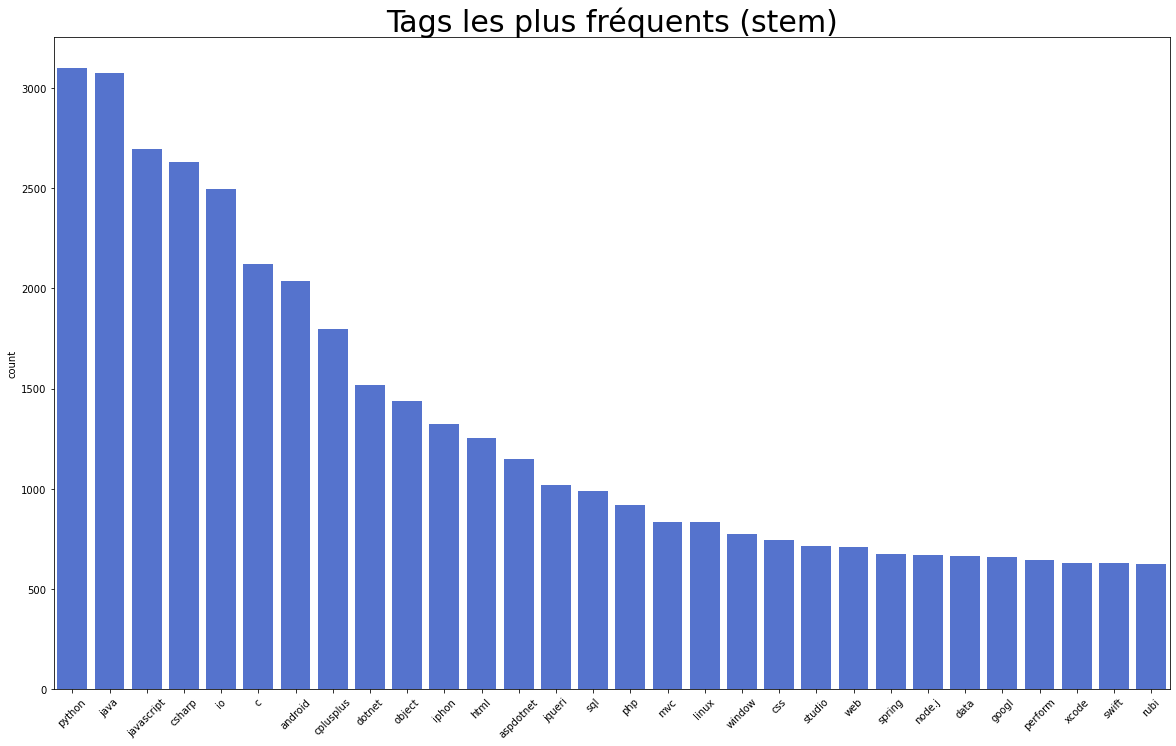

In [47]:
plt.figure(figsize=(20,12))
g = sns.barplot(x=occurance_tags_stem.head(30)['index'], y=occurance_tags_stem.head(30)['count'], color='royalblue')
g.set_title('Tags les plus fréquents (stem)', fontdict = {'fontsize':30})
plt.xticks(rotation=45)
plt.xlabel("")
plt.show()

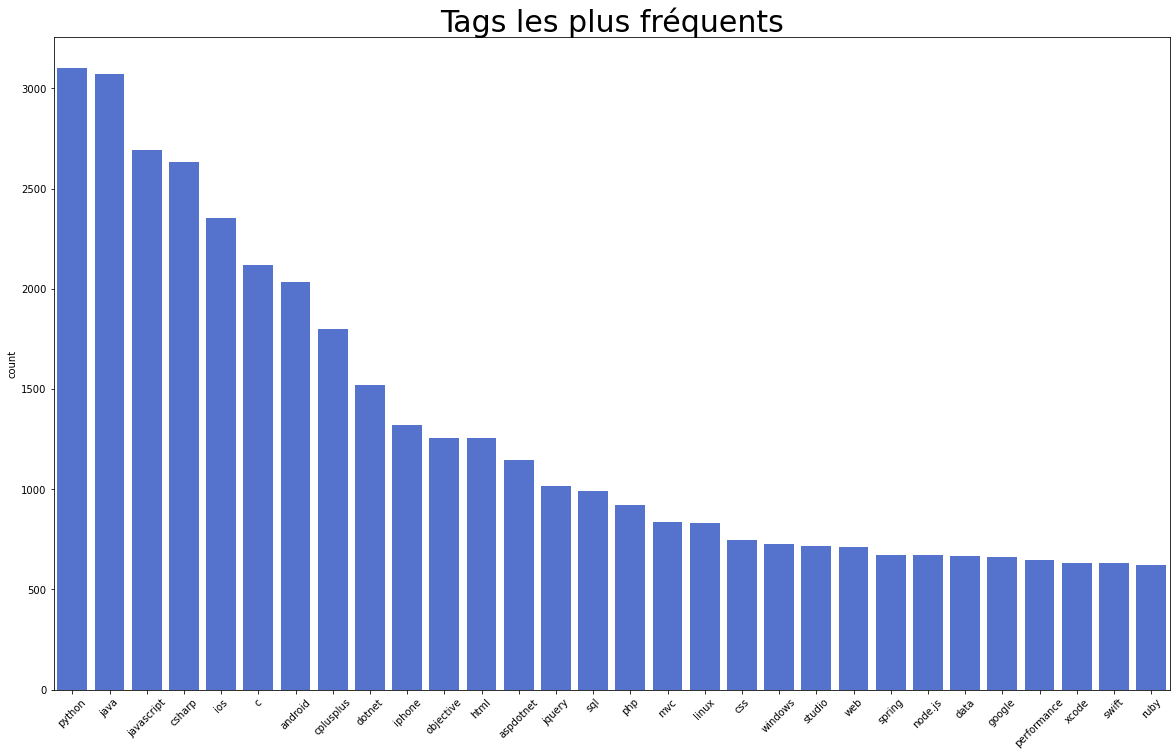

In [48]:
plt.figure(figsize=(20,12))
g = sns.barplot(x=occurance_tags.head(30)['index'], y=occurance_tags.head(30)['count'], color='royalblue')
g.set_title('Tags les plus fréquents', fontdict = {'fontsize':30})
plt.xticks(rotation=45)
plt.xlabel("")
plt.show()

On ne garde finalement que la variable 'Tags' de base.

In [49]:
data = data.drop(['tags_lem', 'tags_stem'], axis=1)

Avec la quantité de données dont nous disposons comparée au nombre de tags différents, il est impossible que nous obtenions de bons résultats lors de la classification supervisée, nous allons réduire le nombre de tags possibles. On ne va garder que les 50 tags les plus fréquents.

In [50]:
list_50_tags = list(occurance_tags.iloc[:50]['index'].values)

In [51]:
data['Tags'] = data['Tags'].apply(lambda x: [t for t in x if t in list_50_tags])

On supprime les questions qui n'ont dorénavant plus de tags.

In [52]:
data['Tags'] = data['Tags'].apply(lambda x: ' '.join([s for s in x]))
data = data[data['Tags']!='']
data['Tags'] = data['Tags'].apply(lambda x: tokenisation(x))

In [53]:
data

,Title,Body,Tags,title_bow_lem,body_bow_lem,title_bow_stem,body_bow_stem
0,spring mvc angularjs file upload org apa...,i have a java spring mvc web application as se...,"[mvc, spring, file, java]","[spring, mvc, angularjs, file, org, apache, fi...","[java, spring, mvc, application, server, angul...","[spring, mvc, angularj, file, org, apach, file...","[java, spring, mvc, applic, server, angularj, ..."
3,what are some examples of design pattern imple...,i m a moderately skilled programmer using java...,"[javascript, design]","[design, javascript]","[programmer, javascript, guru, dom, manipulati...","[design, javascript]","[programm, javascript, guru, dom, manipul, des..."
4,what s the best way to get to know linux or bs...,i d like to gain better knowledge of operating...,[linux],"[linux, bsd]","[knowledge, operating, system, management, mem...","[linux, bsd]","[knowledg, oper, system, manag, memori, manag,..."
5,is there a performance difference between i ...,is there a performance difference between and...,"[performance, c]","[performance, difference, c]","[performance, difference, value]","[perform, differ, c]","[perform, differ, valu]"
6,is there a performance difference between i ...,we have the question is there a performance di...,"[cplusplus, performance]","[performance, difference, cplusplus]","[performance, difference, c, answer, cplusplus]","[perform, differ, cplusplus]","[perform, differ, c, answer, cplusplus]"
...,...,...,...,...,...,...,...
27548,how does keras 1d convolution layer work with ...,i am currently developing a text classificatio...,[python],"[convolution, layer, work, word, classificatio...","[text, classification, tool, validation, accur...","[convolut, layer, work, word, classif, problem...","[text, classif, tool, valid, accuraci, head, c..."
27549,clean architecture design pattern,i have some question about this pattern the...,"[design, java]","[architecture, design, pattern]","[pattern, database, layer, work, reality, enti...","[architectur, design, pattern]","[pattern, databas, layer, work, realiti, entit..."
27550,how to do nd distance and nearest neighbor cal...,this question is intended to be a canonical du...,"[arrays, python]","[distance, neighbor]","[duplicate, target, distance, shape, point, po...","[distanc, neighbor]","[duplic, target, distanc, shape, point, point,..."
27551,android studio emulator is not working on wind...,i have windows 11 on my system the system spe...,"[android, studio, windows]","[studio, emulator, whpx]","[system, system, specifiction, edition, home, ...","[studio, emul, whpx]","[system, system, specifict, edit, home, langua..."


In [54]:
data.reset_index(inplace = True, drop = True)

In [55]:
data.to_csv('data.csv', index=False)

On termine ce notebook par une réduction de dimension.

# t SNE

In [56]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
def list_to_string(l):
    return ' '.join(l)

def get_tsne(data_c):
    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(data_c.apply(lambda x: list_to_string(x)).values)
    tsne = TSNEVisualizer()
    tsne.fit_transform(X)
    tsne.poof()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


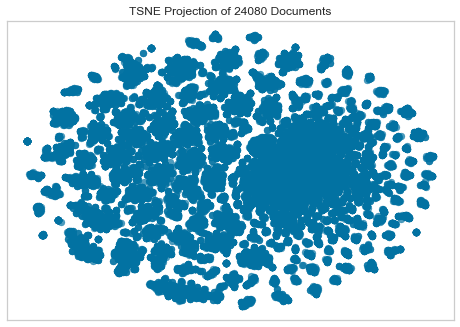

In [58]:
get_tsne(data['title_bow_lem'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


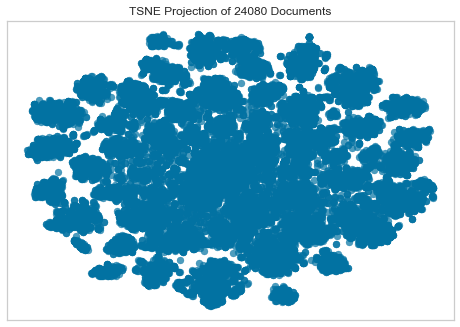

In [59]:
get_tsne(data['body_bow_lem'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


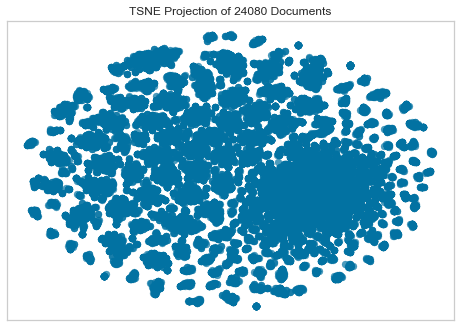

In [60]:
get_tsne(data['title_bow_stem'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


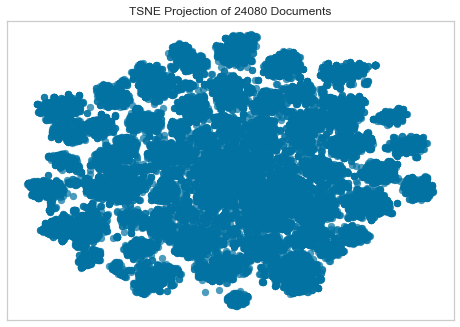

In [61]:
get_tsne(data['body_bow_stem'])